# Colliders and Suppression

The focus in this document is on what Suppression is and how it arises as well as what Colliders are and how they impact analyses.  These are two separate issues that can cause your regression results to lead the modeler down an incorrect path when interpreting the results.  For example, do you really think being obese can have a protective effect on mortality in folks with cardiovascular disease?  Probably not, but a collider in the data can cause that result to come out of the analysis.  Can adding a confound cause another regressor to become *more* significant?  It can if the confound is a suppressor.

Unfortunately with these things there's no way to tell if the problem is present in your data by looking at the data, although knowledge of the variables you've collected (and haven't collected) as well as paying attention to how parameter estimates change while running models can give clues.  Suspecting these things are present requires thinking carefully about your variables, how the data were collected and other factors.  

We won't be talking about prediction models (real prediction) where you can have numerous features trying to predict some outcome (e.g., can brain activation over voxels (voxels = features) predict behavior as quantified using cross validation?).  Due to regularization alone, one shouldn't be attempting to interpret coefficient estimates from these models. In addition to that, consider how these suppression and collider effects can impact parameter estimates.  I would say that in most cases when we try to use brain activation to predict behavior, trying to use the feature weights to claim which brain regions were "important" in the prediction has very little meaning.  

Goals:
* Understand the concept of Suppression
* Undrestand what a collider is and how it can impact regression results

Paper mentioned:
Lewis, J.W., Escobar, L.A., 1986. Suppression and Enhancement in Bivariate Regression. Journal of the Royal Statistical Society. Series D (The Statistician) 35, 17–26. https://doi.org/10.2307/2988294

Related video on MumfordBrainStats:
[Can we say one regressor is "better" than another?](https://www.youtube.com/watch?v=AHfUBqzWIkw)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

cb_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
sns.set_palette(cb_color_cycle)

## Suppression
As the table below walks through, there are different types of suppression.  In classic suppression, if Cor(x1, y) is nonzero and cor(x1, x2) is nonzero while cor(x2, y)=0, then x2 can act as a "suppressor" meaning Cor(x1, y|x2) > Cor(x1, y)!  How does that happen?  A correlation is the shared covariance divided by the product of the (square root of the) unique variances of each variable.  When x2 is conditioned out, it removes some of x1's variability (since cor(x1, x2) is nonzero) but it doesn't touch the variability shared by x1 and y since cor(x2,y) = 0, so the adjusted covariance is the same, the variance of y is unchanged, but the variance of x1 decreases after adjustment and that's what the "suppression" is referring to (canceling out some of x1's variability that doesn't describe y at all).  Generally suppression might be at play if adjusting for a confounder increases the magnitude of a coefficient or decreases the p-value of a variable of interest.

Below I simulate data that generate the various types of suppression as outlined in a table below (from Lewis and Escobar, 1986, recreated from a Cohen paper).  The correlations were chosen based on the conditions listed in the table to generate the different scenarios.  Note, that they assume that if x2 is the potential suppressor then 0< Cor(x2, y) < Cor(x1, y) when assessing the correlations in the table.  This is an assumptions "without loss of generality" meaning if the correlation is negative, just multiply the xi by -1 to flip the sign and the x with the larger correlation (after the sign flipping) is x1.  The b's are the estimated correlations and partial correlations.  I normalize each variable prior to running the regression models so the regression parameter estimates are equal to correlations (neat trick, right?).
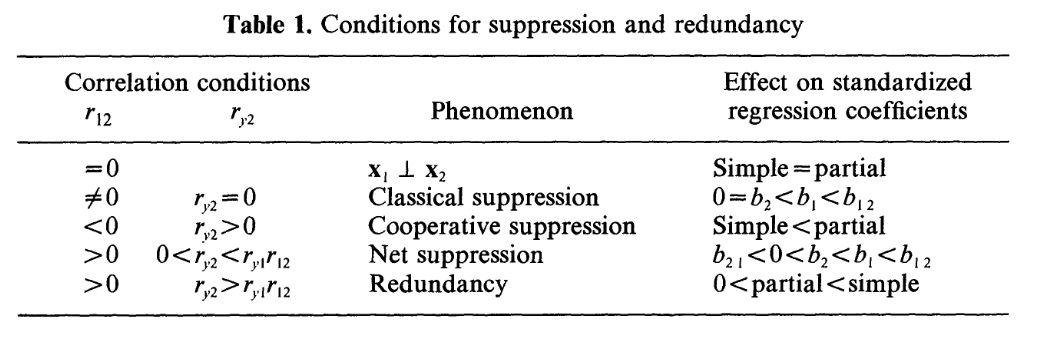


After some functions are defined, each of the examples from the table will be illustrated using simulated data.  The take-away from this is to reinforce what the table is describing.  Important side note: you cannot use the estimated correlations in the above table to try and tease apart whether or not suppression is present (maybe if the sample size was humongous!)

In [2]:
def make_correlated_data(r_y1, r_y2, r_12, nsub):
    """
    Generate some correlated data based on input correlations
    r_y1: Cor(x1, y)
    r_y2: Cor(x2, y)
    r_12: Cor(x1, x2)
    nsub: number of subjects
    """
    mean = np.zeros(3)
    covmat = np.array([[1, r_y1, r_y2], [r_y1, 1, r_12], [r_y2, r_12, 1]])
    data = np.random.multivariate_normal(mean, covmat, nsub)
    data_df = pd.DataFrame(data, columns=['y', 'x1', 'x2'])
    data_df = (data_df - data_df.mean())/data_df.std()
    return data_df


def model_data(data_df):
    """
    Takes the input data frame and runs 4 models
    y ~ x1
    y ~ x2
    y ~ x1 + x2
    x1 ~ x2
    output: dictionary with the parameter estimates and p-values for all parameters
            in the above models. 
    """
    mod_y1 = smf.ols(formula='y ~ x1', data=data_df).fit()
    mod_y2 = smf.ols(formula='y ~ x2', data=data_df).fit()
    mod_y12 = smf.ols(formula='y ~ x1 + x2', data=data_df).fit()
    mod_12 = smf.ols(formula='x1 ~ x2', data=data_df).fit()
    output = {}
    output['b_y1'] = mod_y1.params['x1']
    output['b_y1_p'] = mod_y1.pvalues['x1']
    output['b_y2'] = mod_y2.params['x2']
    output['b_y2_p'] = mod_y2.pvalues['x2']
    output['b_y1_2'] = mod_y12.params['x1']
    output['b_y1_2_p'] = mod_y12.pvalues['x1']
    output['b_y2_1'] = mod_y12.params['x2']
    output['b_y2_1_p'] = mod_y12.pvalues['x2']
    output['b_12'] = mod_12.params['x2']
    output['b_12_p'] = mod_12.pvalues['x2']
    return output


def run_sim(r_y1, r_y2, r_12, nsub, nsim):
    """
    Runs a simulation nsim times where data with the specified
    correlations are generated and modeled and saves out the parameter estimates
    for the following models
    b_y1: x1 coefficient from y ~ x1
    b_y2: x2 coefficient from y ~ x2
    b_y1_2: x1 coefficient from y ~ x1 + x2
    b_y2_1: x2 coefficient from y ~ x1 + x2
    Data have been normalized, so the b's are correlation/partial correlations
    """
    correlations_out = ['b_y1', 'b_y2', 'b_y1_2', 'b_y2_1']
    output = {f'{cor_out}_all': np.zeros(nsim) for cor_out in correlations_out}

    for sim in range(nsim):
        data_df = make_correlated_data(r_y1, r_y2, r_12, nsub)
        out = model_data(data_df)
        for cor_out in correlations_out:
            output[f'{cor_out}_all'][sim] = out[cor_out]
    return output


def make_plot(sim_out, phenomenon_name, phenomenon_check,
              r_y1, r_y2, r_12):
    """
    Plots simulation output
    """
    #plt.figure(figsize=(15, 8))
    plt.plot(sim_out['b_y1_2_all'], label='b_y1 adj 2')
    plt.plot(sim_out['b_y1_all'], label='b_y1')
    plt.plot(sim_out['b_y2_1_all'], label='b_y2 adj 1')
    plt.plot(sim_out['b_y2_all'], label='b_y2')
    plt.legend(loc='lower right')
    plt.title(f'{phenomenon_name} \n is {phenomenon_check}'
            f'\n r_y1={r_y1}, r_y2={r_y2}, r_12={r_12}')
    plt.xlabel('Simulation number')
    plt.ylabel('Correlation (or Partial Correlation)')
    plt.tight_layout()
    plt.show()
    

#### Simple = Partial

Were the correlations chosen properly for simple = partial? True


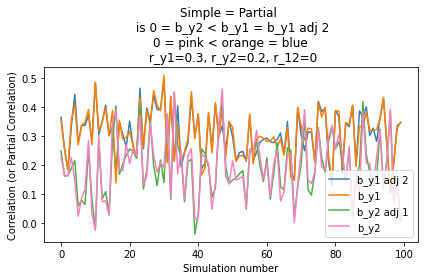

In [3]:
#Simple = Partial
nsub = 100
phenomenon_name = 'Simple = Partial'
phenomenon_check = ('0 = b_y2 < b_y1 = b_y1 adj 2\n'
                    '0 = pink < orange = blue')
r_y1 = .3
r_y2 = .2
r_12 = 0

check = (r_12 == 0) and (r_y2 < r_y1)
print(f'Were the correlations chosen properly for simple = partial? {check}')

nsim = 100
sim_out = run_sim(r_y1, r_y2, r_12, nsub, nsim)
make_plot(sim_out, phenomenon_name, phenomenon_check,
          r_y1, r_y2, r_12)

#### Classic suppression

Were the correlations chosen properly for classic suppression? True


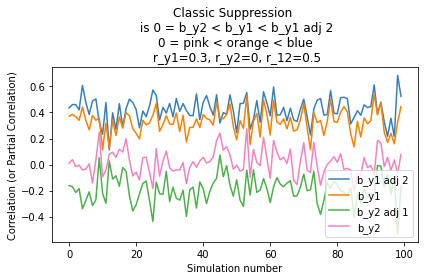

In [4]:
#Classic suppression: cor(x1, y)>0, cor(x2, y) = 0, cor(x1, x2) nonzero
nsub = 100
phenomenon_name = 'Classic Suppression'
phenomenon_check = ('0 = b_y2 < b_y1 < b_y1 adj 2\n'
                    '0 = pink < orange < blue')
r_y1 = .3
r_y2 = 0
r_12 = .5

check = (r_12 != 0) and (r_y2 == 0)
print(f'Were the correlations chosen properly for classic suppression? {check}')

nsim = 100
sim_out = run_sim(r_y1, r_y2, r_12, nsub, nsim)
make_plot(sim_out, phenomenon_name, phenomenon_check,
          r_y1, r_y2, r_12)


#### Cooperative Suppression

Were the correlations chosen properly for cooperative suppression? True


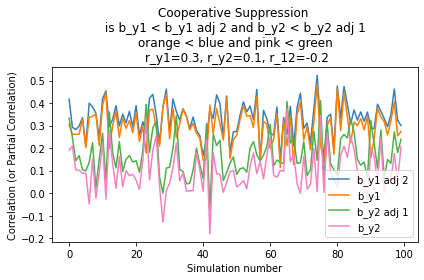

In [5]:
#Cooperative suppression: cor(x1, y)>0, cor(x2, y) >0, cor(x1, x2)<0
phenomenon_name = 'Cooperative Suppression'
phenomenon_check = ('b_y1 < b_y1 adj 2 and b_y2 < b_y2 adj 1 \n'
                    'orange < blue and pink < green')
nsub = 100
r_y1 = .3
r_y2 = 0.1
r_12 = -.2

check = (r_y1 > 0) & (r_y2 > 0) & (r_12 < 0)
print(f'Were the correlations chosen properly for cooperative suppression? {check}')

nsim = 100
sim_out = run_sim(r_y1, r_y2, r_12, nsub, nsim)
make_plot(sim_out, phenomenon_name, phenomenon_check,
          r_y1, r_y2, r_12)


Below is just a different cooperative suppression example.  I was interested to see what happened if I tinkered with the numbers more to see if I could make a bigger gap between the orange/blue lines.

Were the correlations chosen properly for cooperative suppression? True


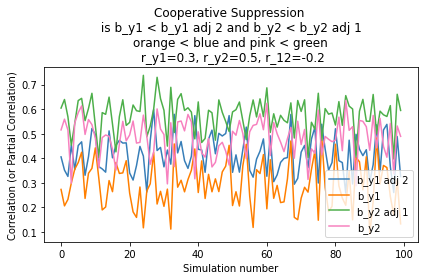

In [6]:
#Cooperative suppression: cor(x1, y)>0, cor(x2, y) >0, cor(x1, x2)<0
# Larger difference when r_y2 is increased
phenomenon_name = 'Cooperative Suppression'
phenomenon_check = ('b_y1 < b_y1 adj 2 and b_y2 < b_y2 adj 1 \n'
                    'orange < blue and pink < green')
nsub = 100
r_y1 = .3
r_y2 = 0.5
r_12 = -.2

check = (r_y1 > 0) & (r_y2 > 0) & (r_12 < 0)
print(f'Were the correlations chosen properly for cooperative suppression? {check}')

nsim = 100
sim_out = run_sim(r_y1, r_y2, r_12, nsub, nsim)
make_plot(sim_out, phenomenon_name, phenomenon_check,
          r_y1, r_y2, r_12)

#### Net suppression

Were the correlations chosen properly for Net Suppression?  True


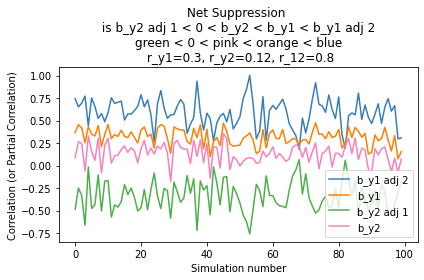

In [7]:
#Net suppression: 0<cor(y, x2)<cor(y, x1)*cor(x1, x2), cor(x1, x2)>0
phenomenon_name = 'Net Suppression'
phenomenon_check = ('b_y2 adj 1 < 0 < b_y2 < b_y1 < b_y1 adj 2 \n'
                    'green < 0 < pink < orange < blue')
nsub = 100
r_y1 = .3
r_12 = .8
# This will ensure r_y2 satisfies the above inequality
r_y2 = np.round(r_y1*r_12 - .5*(r_y1*r_12), 2)

check = (r_y2 > 0) & (r_y2 < r_y1*r_12)
print(f'Were the correlations chosen properly for Net Suppression?  {check}')

nsim = 100
sim_out = run_sim(r_y1, r_y2, r_12, nsub, nsim)
make_plot(sim_out, phenomenon_name, phenomenon_check,
          r_y1, r_y2, r_12)

Another net suppression example since I was interested to see what happened if r_12 was smaller (orange/blue lines are closer  and green/pink lines are closer).

Were the correlations chosen properly for Net Suppression?  True


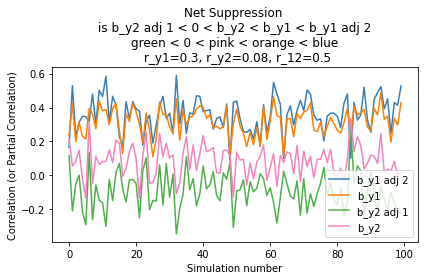

In [8]:
#Net suppression: 0<cor(y, x2)<cor(y, x1)*cor(x1, x2), cor(x1, x2)>0
# Make r_12 smaller to see what happens
phenomenon_name = 'Net Suppression'
phenomenon_check = ('b_y2 adj 1 < 0 < b_y2 < b_y1 < b_y1 adj 2 \n'
                    'green < 0 < pink < orange < blue')
nsub = 100
r_y1 = .3
r_12 = .5
# This will ensure r_y2 satisfies the above inequality
r_y2 = np.round(r_y1*r_12 - .5*(r_y1*r_12), 2)

check = (0 < r_y2) & (r_y2 < r_y1*r_12) & (r_12 > 0)
print(f'Were the correlations chosen properly for Net Suppression?  {check}')

nsim = 100
sim_out = run_sim(r_y1, r_y2, r_12, nsub, nsim)
make_plot(sim_out, phenomenon_name, phenomenon_check,
          r_y1, r_y2, r_12)

#### Redundancy

Just what we'd expect if we didn't know about suppression: adding a regressor makes the coefficient smaller.

Were the correlations chosen properly for Redundancy?  True


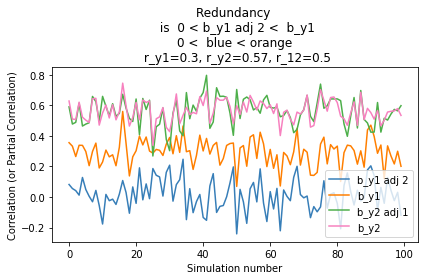

In [9]:
#Redundancy: cor(y, x2) > cor(y, x1)*cor(x1, x2), cor(x1, x2)>0
phenomenon_name = 'Redundancy'
phenomenon_check = (' 0 < b_y1 adj 2 <  b_y1\n'
                    '0 <  blue < orange')
nsub = 100
r_y1 = .3
r_12 = .5
# This will ensure r_y2 satisfies the above inequality
r_y2 = np.round(r_y1*r_12 + .5*(1-(r_y1*r_12)), 2)

check = (r_y2 > r_y1*r_12) & (r_12 > 0) 
print(f'Were the correlations chosen properly for Redundancy?  {check}')

nsim = 100
sim_out = run_sim(r_y1, r_y2, r_12, nsub, nsim)
make_plot(sim_out, phenomenon_name, phenomenon_check,
          r_y1, r_y2, r_12)

If you'd like to take a closer look at suppression and also mediation and confounders, which are not covered here, [this](https://pubmed-ncbi-nlm-nih-gov.laneproxy.stanford.edu/11523746/) seemed like an okay article.

## Colliders

To understand what a collider is we need to dip our toes into understanding directed graphs, which describe causal relationships between variables.  If you'd like to go ankle deep, [this](https://osf.io/c4vz7/download) looked useful. A directed acyclic network (DAG) consists of nodes (our variables which may be observed or unobserved) and edges which describe causal relationships.  A fork is when one node causes two other variables, like $A \leftarrow B \rightarrow C$, and in this case A & C are correlated, but if we condition on B (or fix the value of B), they become independent (I'm skipping the math, so you'll need to take my word for it!).  A chain looks like $A \rightarrow B \rightarrow C$ and in this case is is also the case that A and C will be correlated, but if you were to condition on B (or fix the value of B), they would be independent.  The collider is the focus here and looks like $A \rightarrow B \leftarrow C$, where both A and C cause B.  This case is a little more interesting because A and C are independent *until* you condition on B!  Specifically, Cor(A, C) = 0, but if we partial out C it the correlation is nonzero, Cor(A, C | B) $\neq0$.  For example, kidney disease and lead poisoning can lead to reduced kidney function (low GFR):
$$ \text{lead poisoning} \rightarrow \text{GFR} \leftarrow \text{kidney disease}.$$
Generally, kidney disease and lead poisoning are not correlated, but if we know the GFR is low and it isn't lead poisoning that informs us that it might be kidney disease.  

Typically the colliders are more sneaky than that!  Recall the act of conditioning sets some variable to the same value for all subjects before making the other comparison.  For example, recall a two group comparison adjusted for age equates the ages of the two groups before making the comparison and that's what the adjustment is.  

A way to do condition on a collider outside of the model is to directly accidentally introduce an "adjustment" when collecting the data.  For example, if a sample is restricted to people with cardiovascular disease, obesity has been shown to have a *protective* effect against mortality, which is super counterintuitive and likely an error.  The collider here is cardiovascular disease where some unmeasured variable, say a genetic factor, causes both the cardiovascular disease.  The graph quickly becomes more complicated, but you can see that cardiovascular disease has 2 arrows going into it, which indicates it is a collider.

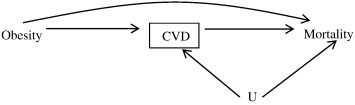


We'll be working with a simpler graph, which is shown after the code below.


In [10]:
def check_phenomenon_based_on_truth(cormat):
    """
    This function is a bit iffy.  Not 100% sure it works correctly
    Follows the criteria from the Cohen table in "Suppression and
    Enhancement in Bivariate Regresson" by Lewis and Escobar (1986,
    The Statistician).
    Function takes in a correlation matrix and flips the signs of 
     r_y1/y_12 if r_y1<0 and r_y2/y_12 if r_y2<0 so the table properties hold.
     Then simply uses the conditions outlined in the table to figure out what type
     of suppression or redundancy is present.  
    cormat: a correlation matrix.  Assumes sample size was large enough that
            we can assume these correlations are very close to the truth.
    returns: message with guess about whether x2 is suppressor/redundant or neither
             in the case where x1 might be the suppressor/redundant
    """

    r_y1 = cormat.loc['y', 'x1']
    r_y2 = cormat.loc['y', 'x2']
    r_12 = np.round(cormat.loc['x1', 'x2'], 3) # fair chance to be zero
    # Flip sign if correlation is negative
    # (equivalent to multiplying xi by -1)
    if r_y1<0:
        r_y1 = -1*r_y1
        r_12 = -1*r_12
    if r_y2<0:
        r_y2 = -1*r_y2
        r_12 = -1*r_12
    checks = {
        'independence': (r_12 == 0),
        'classic_suppression': (r_12 != 0) & (r_y2 == 0),
        'cooperative_suppression':  (r_y1 > 0) & (r_y2 > 0) & (r_12 < 0),
        'net_suppression':  (0 < r_y2) & (r_y2 < r_y1*r_12) & (r_12 > 0),
        'redundancy':  (r_y2 > r_y1*r_12) & (r_12 > 0)}
    found_match = False
    if r_y2 > r_y1:
        print('r_y2>r_y1, so x2 is not suppressor (maybe x1 is?)')
        found_match = True
    else:
        for key, func in checks.items():
            if func:
                print(key)
                found_match = True
    if not found_match:
        print("no match was found")


In [11]:
def assess_collider(x1, x2, y):
    """
    This function makes a guess at whether or not x2 is a suppressor/redundant variable
    note, I'm not 100% confident that check_phenomenon_based_on_truth() is totally correct
    Also runs the regression models after normalizing the data so the regression parameters
    are correlations/partial correlations.
    input: x1, x2, y.  x2 is assumed to be a collider
    """
    df = pd.DataFrame({'x1': x1, 
                    'x2': x2,
                    'y': y})
    cormat = df.corr()
    print(cormat)
    print('\n')
    print('Our best guess at "truth" assuming sample correlation is "truth":')
    check_phenomenon_based_on_truth(cormat)
    print('\n')

    # Standardizing ensures regression coefficients are correlations/partial correlations
    df = df/df.std()
    mod1 = smf.ols(formula='y ~ x1', data=df).fit()
    print(mod1.summary(slim=True))

    mod2 = smf.ols(formula='y ~ x1 + x2', data=df).fit()
    print(mod2.summary(slim=True))

In [12]:
# Code to draw out the collider model
# (w1) and (w2) are unobserved

def plot_graph(w1_to_x2, w2_to_x2, w1_to_x1, w2_to_y, x1_to_y):
    w1 = (0, 1)
    w2 = (1, 1)
    x2 = (.5, .5)
    y = (1, 0)
    x1 = (0, 0)

    w1_to_x1_loc = ( (w1[0]+x1[0])/2, (w1[1]+x1[1])/2)
    w1_to_x2_loc = ( (w1[0]+x2[0])/2, (w1[1]+x2[1])/2)
    w2_to_x2_loc = ( (w2[0]+x2[0])/2, (w2[1]+x2[1])/2)
    w2_to_y_loc = ( (w2[0]+y[0])/2, (w2[1]+y[1])/2)
    x1_to_y_loc = ( (x1[0]+y[0])/2, (x1[1]+y[1])/2)

    plt.figure(figsize=(3, 3))
    plt.annotate('(w1)', xy=w1, xytext=w1, va = "bottom", ha="center", fontsize=20)
    plt.annotate('(w2)', xy=w2, xytext=w2, va = "bottom", ha="center", fontsize=20)
    plt.annotate('x2', xy=x2, xytext=x2, va = "top", ha="center", fontsize=20)
    plt.annotate('x1', xy=x1, xytext=x1, va = "top", ha="center", fontsize=20)
    plt.annotate('y', xy=y, xytext=y, va = "top", ha="center", fontsize=20)
    plt.annotate( "", xy=w1, xytext=x2, arrowprops=dict( arrowstyle="<-" ))
    plt.annotate( "", xy=w2, xytext=x2, arrowprops=dict( arrowstyle="<-" ))
    plt.annotate( "", xy=x1, xytext=y, arrowprops=dict( arrowstyle="<-" ))
    plt.annotate( "", xy=w1, xytext=x1, arrowprops=dict( arrowstyle="<-" ))
    plt.annotate( "", xy=w2, xytext=y, arrowprops=dict( arrowstyle="<-" ))
    plt.annotate(w1_to_x2, xy=w1_to_x2_loc, xytext=w1_to_x2_loc, va = "bottom", 
                ha="left", fontsize=8)
    plt.annotate(w2_to_x2, xy=w2_to_x2_loc, xytext=w2_to_x2_loc, va = "bottom", 
                ha="right", fontsize=8)
    plt.annotate(w1_to_x1, xy=w1_to_x1_loc, xytext=w1_to_x1_loc, va = "bottom", 
                ha="right", fontsize=8)
    plt.annotate(w2_to_y, xy=w2_to_y_loc, xytext=w2_to_y_loc, va = "bottom", 
                ha="right", fontsize=8)
    plt.annotate(x1_to_y, xy=x1_to_y_loc, xytext=x1_to_y_loc, va = "bottom", 
                ha="right", fontsize=8)
    plt.axis('off')
    plt.title('Underlying model of simulated collider, x2. \n (w1) and (w2) are unobserved', 
            fontsize=15, pad=50)
    plt.show()

Below is the base graph the examples will be based off of.  The "classic" collider example typically does not have a connection between $x1$ and $y$, which we can easily do by setting that connection to 0.  Along the way let's think about how this may or may not relate to the last topic, suppression.  Warning:  This is my first time thinking this through and I may make errors :)

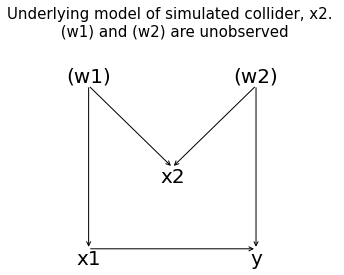

In [13]:
plot_graph('','','','','')

#### Classic collider example
In the classic example, Cor(x1, y) = 0.  Let's go through the possibilities for suppression to see if any can occur (from the table above).  Recall the assumptions made (without loss of generality) for this table are: 
* Cor(x1, y)>=0 and Cor(x2, y) >=0 (if one is negative, just multiple xi by -1)
* x1 has the larger correlation Cor(x1, y)> Cor(x2, y)

Let's focus on whether x2 can be both a suppressor and a collider. If Cor(x1, y) = 0, then it cannot be the case that x2 is a suppressor variable, since Cor(x2, y) cannot be smaller than Cor(x1, y) while still being positive.  See the next "experimental thoughts" section where I attempt to combine a collider with different suppression/redundancy scenarios from the table in the suppression section when Cor(x1, y) is nonzero.

First, let's check out the classic collider output!

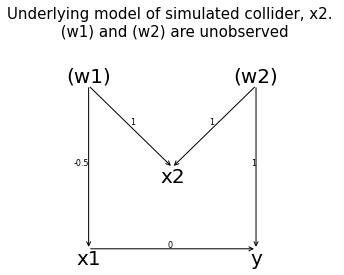

          x1        x2         y
x1  1.000000 -0.258329  0.001266
x2 -0.258329  1.000000  0.403115
y   0.001266  0.403115  1.000000


Our best guess at "truth" assuming sample correlation is "truth":
r_y2>r_y1, so x2 is not suppressor (maybe x1 is?)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
No. Observations:               10000   F-statistic:                   0.01603
Covariance Type:            nonrobust   Prob (F-statistic):              0.899
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.010      0.500      0.617      -0.015       0.025
x1             0.0013      0.010      0.127      0.899      -0.018       0.021

Notes:
[1] Standard Errors assume th

In [14]:
#  Classic example Cor(x1, y) = 0

n = 10000
# Unobserved
w1 = np.random.normal(0, 1, n)
w2 = np.random.normal(0, 1, n)
# Observed
w1_to_x2 = 1
w2_to_x2 = 1
w1_to_x1 = -.5
w2_to_y = 1
x1_to_y = 0

x2 = w1_to_x2 * w1 + w2_to_x2 * w2 + np.random.normal(0, 1, n)
x1 = w1_to_x1 * w1 + np.random.normal(0, 1, n)
y = x1_to_y * x1 + w2_to_y * w2 + np.random.normal(0, 1, n)

plot_graph(w1_to_x2, w2_to_x2, w1_to_x1, w2_to_y, x1_to_y)
assess_collider(x1, x2, y)

## Experimenting with ideas
## read with caution

Here I am toying around with trying to combine suppression/redundancy within the collider setting.  By setting the sample size really large it seems safe to assume the estimated correlations are near truth.  Then I check whether Cor(x1,y)>0 and Cor(x2, y)>0, if one/both are negative I flip the sign of that correlation and Cor(x1, x2) (analogous to multiplying the xi by -1, which is what the table of suppression/redundancy relationships assumes).  If Cor(x1, y) < Cor(x2, y), then x2 cannot be the suppressor, since Cor(x1, y) has to be the larger one. I assumed that in that case perhaps x1 was a suppressor, but didn't look into it further since I was interested in a variable that was both the suppressor and a collider.

This is just me messing around and my thought process could be wrong or perhaps it is limiting to only consider this specific collider graph structure.  In the following examples I relax the assumption that Cor(x1,y) = 0 and in that case I wonder if the impact of the collider is lessened?  Not sure.  Either way, it seems a combination of things can likely be happening.

Here are my best guesses about the possibilities of the other scenarios from the table above.

* Classic suppression?  
    * No, since cor(x2, y) won't be zero since (w2) causes both x2 and y.
* Cooperative Suppression?  
    * I believe so (see settings below that I used)
* Net Suppression? 
    * I believe so (see settings below)
* Redundancy?  
    * I believe so (see settings below)

#### Collider with possible Cooperative Suppressor

The coefficient goes up a little bit in the adjusted model, but is that the suppression or the collider at work?  Presumably both?  The correlation between x1 and y is so high, that I wonder if that reduces the impact of a collider. (speculation)

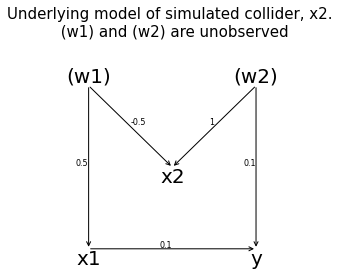

          x1        x2         y
x1  1.000000 -0.176356  0.120343
x2 -0.176356  1.000000  0.047157
y   0.120343  0.047157  1.000000


Our best guess at "truth" assuming sample correlation is "truth":
cooperative_suppression


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
No. Observations:               10000   F-statistic:                     146.9
Covariance Type:            nonrobust   Prob (F-statistic):           1.40e-33
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0007      0.010     -0.069      0.945      -0.020       0.019
x1             0.1203      0.010     12.121      0.000       0.101       0.140

Notes:
[1] Standard Errors assume that the covariance matrix o

In [15]:
n = 10000
# Unobserved
w1 = np.random.normal(0, 1, n)
w2 = np.random.normal(0, 1, n)
# Observed
w1_to_x2 = -.5
w2_to_x2 = 1
w1_to_x1 = .5
w2_to_y = .1
x1_to_y = .1

x2 = w1_to_x2 * w1 + w2_to_x2 * w2 + np.random.normal(0, 1, n)
x1 = w1_to_x1 * w1 + np.random.normal(0, 1, n)
y = x1_to_y * x1 + w2_to_y * w2 + np.random.normal(0, 1, n)

plot_graph(w1_to_x2, w2_to_x2, w1_to_x1, w2_to_y, x1_to_y)
assess_collider(x1, x2, y)

#### Collider with possible net suppression

At least with these settings, there's just a slight change in cor(y, x1 | x2).  Also, Cor(y, x2| x1) is negative while Cor(x2,y)>0 (not sure if that's a fluke).  Both follow expectations of x2 causing net suppression.

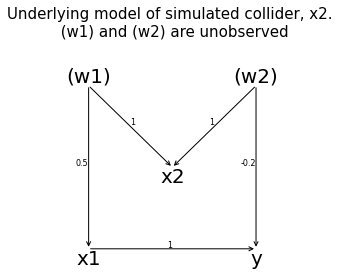

          x1        x2         y
x1  1.000000  0.267526  0.738628
x2  0.267526  1.000000  0.122740
y   0.738628  0.122740  1.000000


Our best guess at "truth" assuming sample correlation is "truth":
net_suppression


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
No. Observations:               10000   F-statistic:                 1.200e+04
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0058      0.007      0.864      0.387      -0.007       0.019
x1             0.7386      0.007    109.559      0.000       0.725       0.752

Notes:
[1] Standard Errors assume that the covariance matrix of the er

In [16]:
n = 10000
# Unobserved
w1 = np.random.normal(0, 1, n)
w2 = np.random.normal(0, 1, n)
# Observed
w1_to_x2 = 1
w2_to_x2 = 1
w1_to_x1 = .5
w2_to_y = -.2
x1_to_y = 1

x2 = w1_to_x2 * w1 + w2_to_x2 * w2 + np.random.normal(0, 1, n)
x1 = w1_to_x1 * w1 + np.random.normal(0, 1, n)
y = x1_to_y * x1 + w2_to_y * w2 + np.random.normal(0, 1, n)

plot_graph(w1_to_x2, w2_to_x2, w1_to_x1, w2_to_y, x1_to_y)
assess_collider(x1, x2, y)

#### Collider with possible redundancy

 With a redundancy we should see 0< paritial < simple and that seems to be the case!  No sign of the collider doing anything.  I wonder if the collider could override the redundancy.  Fiddle with the numbers if you'd like to try!

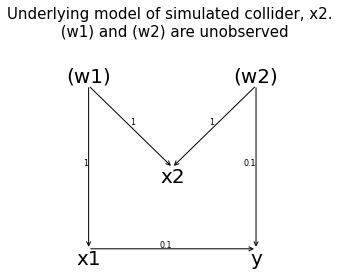

          x1        x2         y
x1  1.000000  0.421904  0.139754
x2  0.421904  1.000000  0.096209
y   0.139754  0.096209  1.000000


Our best guess at "truth" assuming sample correlation is "truth":
redundancy


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
No. Observations:               10000   F-statistic:                     199.2
Covariance Type:            nonrobust   Prob (F-statistic):           8.56e-45
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0114      0.010     -1.147      0.252      -0.031       0.008
x1             0.1398      0.010     14.112      0.000       0.120       0.159

Notes:
[1] Standard Errors assume that the covariance matrix of the errors 

In [17]:
n = 10000
# Unobserved
w1 = np.random.normal(0, 1, n)
w2 = np.random.normal(0, 1, n)
# Observed
w1_to_x2 = 1
w2_to_x2 = 1
w1_to_x1 = 1
w2_to_y = 5
x1_to_y = 5

w1_to_x2 = 1
w2_to_x2 = 1
w1_to_x1 = 1
w2_to_y = .1
x1_to_y = .1

x2 = w1_to_x2 * w1 + w2_to_x2 * w2 + np.random.normal(0, 1, n)
x1 = w1_to_x1 * w1 + np.random.normal(0, 1, n)
y = x1_to_y * x1 + w2_to_y * w2 + np.random.normal(0, 1, n)

plot_graph(w1_to_x2, w2_to_x2, w1_to_x1, w2_to_y, x1_to_y)

#x2 = w1 + w2 + np.random.normal(0, 1, n)
#x1 = w1 + np.random.normal(0, 1, n)
#y = x1 + 10*w2 + np.random.normal(0, 1, n)

assess_collider(x1, x2, y)